# 1 Introduction

This project is based on the criteria from a Kaggle Histopathological Cancer Detection Competition:

https://www.kaggle.com/c/histopathologic-cancer-detection/overview

## 1.1 Problem Description

The premise of this competition is to develop an algorithm capable of identifying metastatic cancer in selections of histopathological scans of lymph nodes. The task is to classify small image patches extracted from larger digital pathology scans as either containing metastatic tissue or not. This binary image classification project utilizes various machine learning techniques, particularly convolutional neural networks (CNN).

## 1.2 Dataset Import

The data can be found at:

https://www.kaggle.com/c/histopathologic-cancer-detection/data

### Data Import

The dataset is comprised of image patches that have been selected from whole slide images. Each image patch has an associated label which indicates whether the image patch contains metastatic tissue (1) or not (0). The data is provided in the form of training and test sets an their corresponding labels.

The data is imported using the Kaggle API to download and extract the images. This includes four files consisting of the of training images, training labels, test images, and test labels.

### Dataset Overview

The dataset is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset, which has been pre-curated to eliminate duplicate images.

The following code snippets are the process of downloading, extracting, preparing, and displaying a selection of the data.

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c histopathologic-cancer-detection
# Unzip and load the dataset
import zipfile
zip = zipfile.ZipFile('histopathologic-cancer-detection.zip')
zip.extractall()
%config IPCompleter.greedy=True
%config Completer.use_jedi=False
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi=False
%config Completer.use_jedi=False
%config IPCompleter.use_jedi=False
%config InlineBackend.figure_format='retina'

100% 6.30G/6.31G [00:43<00:00, 192MB/s]
100% 6.31G/6.31G [00:43<00:00, 154MB/s]


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
import warnings
import torchvision.transforms as transforms
# from skimage.feature import greycomatrix, greycoprops
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from PIL import UnidentifiedImageError
from tqdm import tqdm
import copy
import time
from google.colab import drive

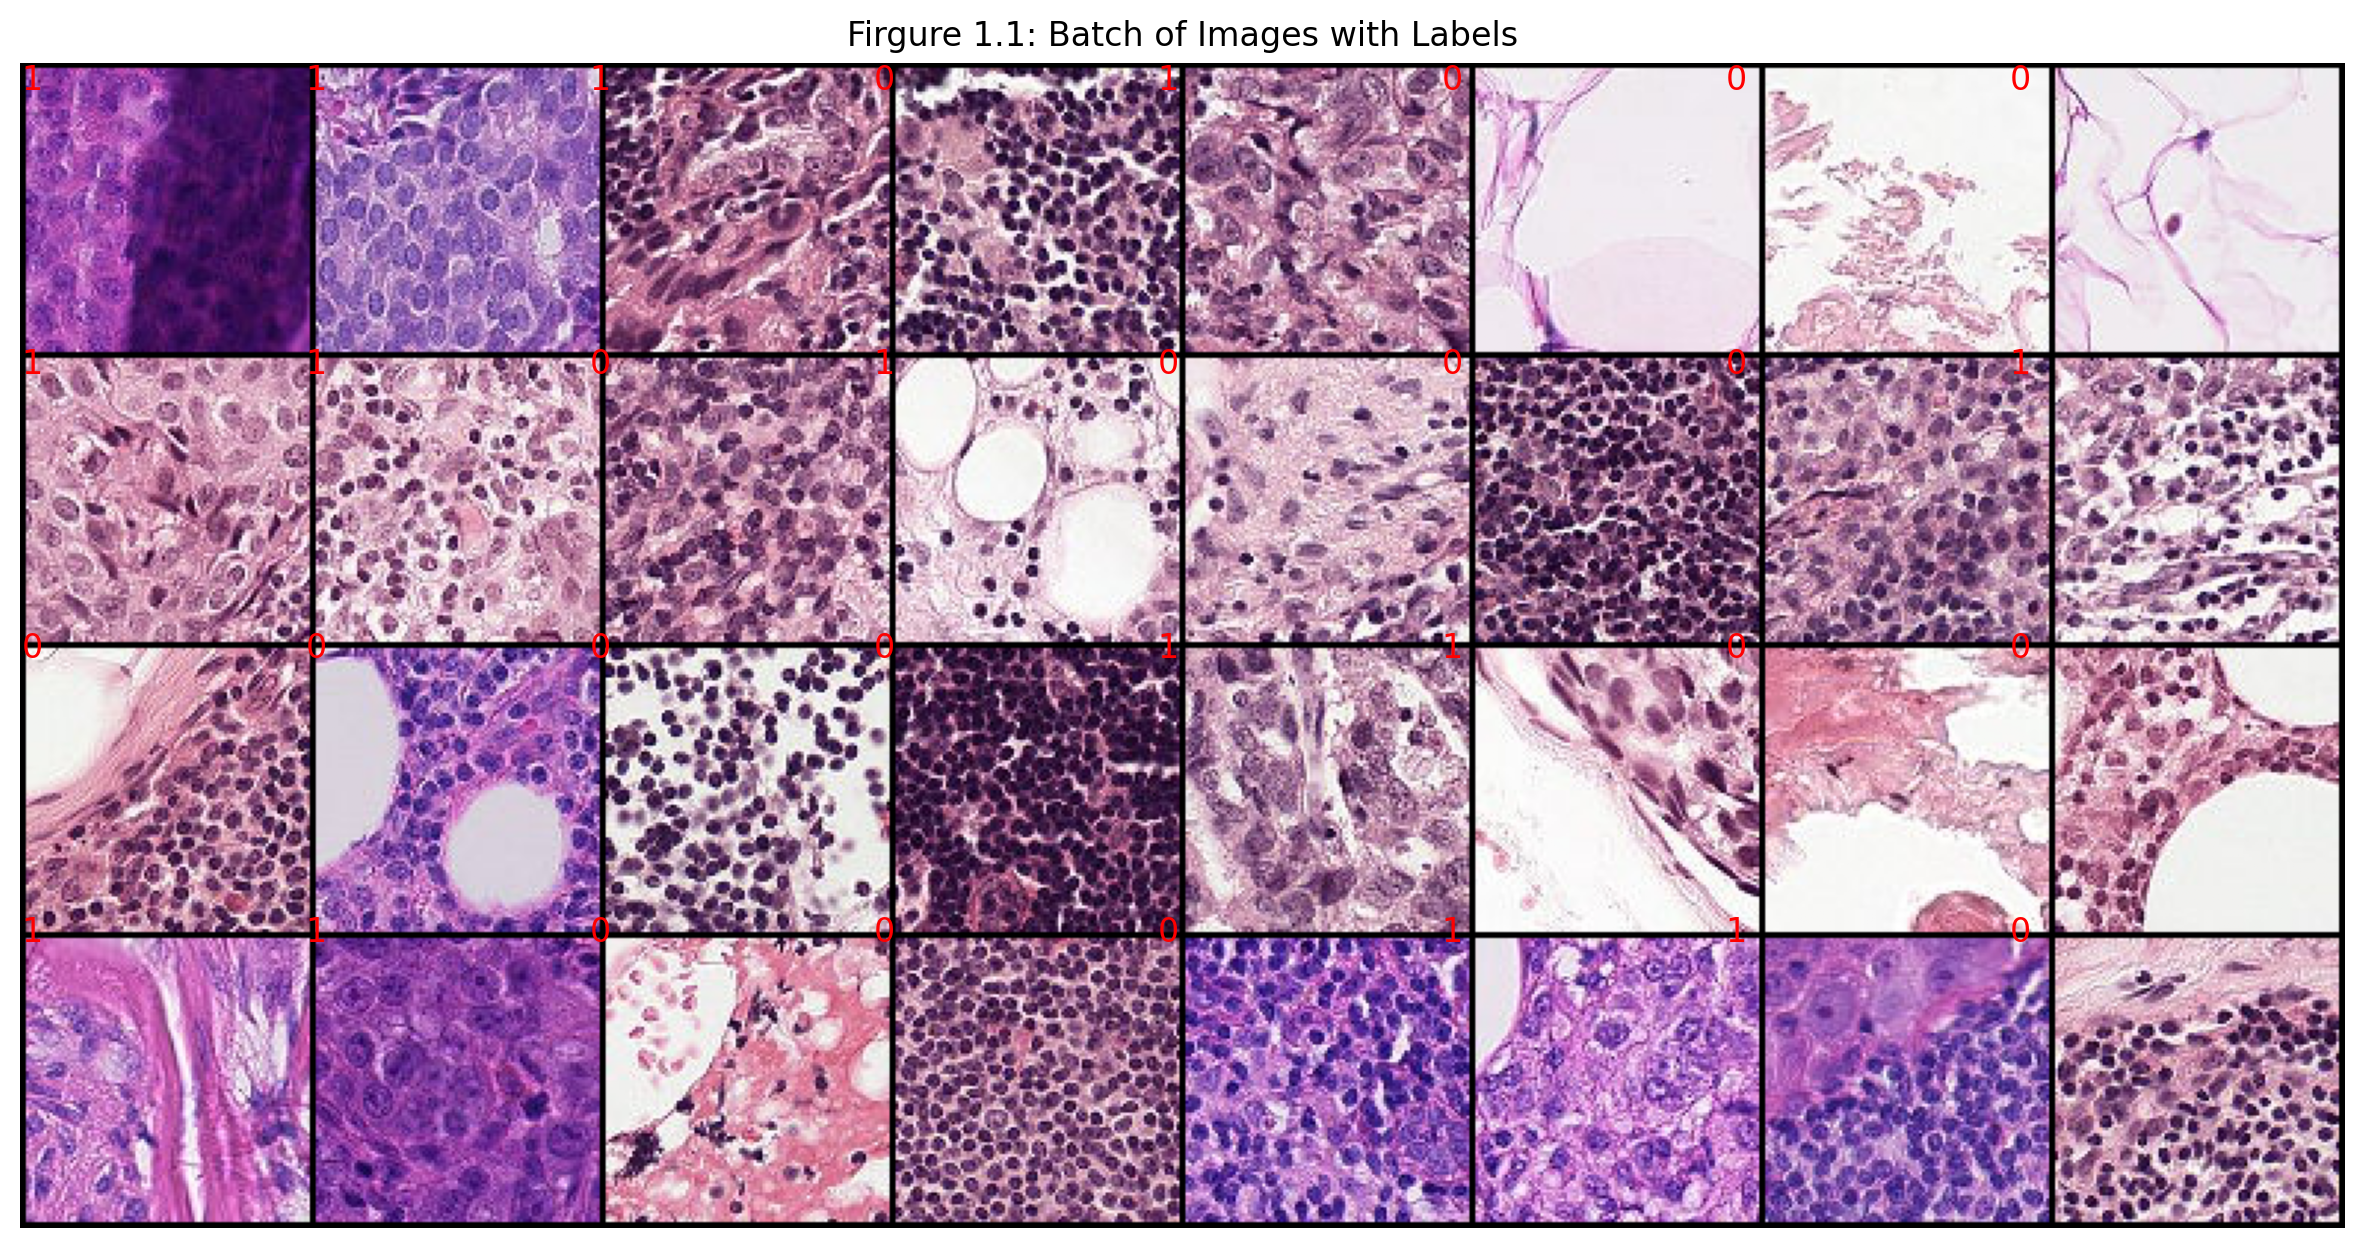

In [ ]:
class HistopathologicDataset(Dataset):
    def __init__(self, labels, img_dir, transform=None):
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx, 0]
        img_label = self.labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, f'{img_id}.tif')
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, img_label

transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the training set
train_labels = pd.read_csv('train_labels.csv')
train_dataset = HistopathologicDataset(labels=train_labels, img_dir='train', transform=transform)

# Load the test set
test_labels = pd.read_csv('sample_submission.csv')
test_dataset = HistopathologicDataset(labels=test_labels, img_dir='test', transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def display_batch(dataloader):
    batch = next(iter(dataloader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')

    for i in range(len(labels)):
        plt.text(x=(i % 8) * 96, y=(i // 8) * 96, s=str(labels[i].item()),
                 color='red', fontsize=12, verticalalignment='top')

    plt.title('Firgure 1.1: Batch of Images with Labels')
    plt.show()

# Display a batch of training images
display_batch(train_dataloader)

# # Display a batch of test images
# display_batch(test_dataloader)

# 2 Exploratory Data Analysis (EDA)

## 2.1 Missing and Duplicate Data

Note that as per the competition description, there are no duplicate images. The code verifies that there is no missing data and no corrupted images:

In [ ]:
# Check for missing values in the labels
missing_labels = train_labels.isnull().sum()
print(missing_labels)

def check_corrupted_images(img_dir):
    corrupted_images = []
    for filename in os.listdir(img_dir):
        if filename.endswith('.tif'):
            img_path = os.path.join(img_dir, filename)
            try:
                img = Image.open(img_path)
                img.verify()  # Check if the image is corrupted
            except (IOError, SyntaxError, UnidentifiedImageError) as e:
                corrupted_images.append(filename)
    return corrupted_images

# List of corrupted images
corrupted_images = check_corrupted_images('train')
print(f"Corrupted images: {corrupted_images}")

# # Remove corrupted images from the labels DataFrame
# train_labels = train_labels[~train_labels['id'].isin(corrupted_images)]

id       0
label    0
dtype: int64
Corrupted images: []


## 2.2 Image Pixels

Figure 2.1 below reveals that all images have a consistent width and height of 96 pixels by 96 pixels as illustrated by the single dot on the plot.

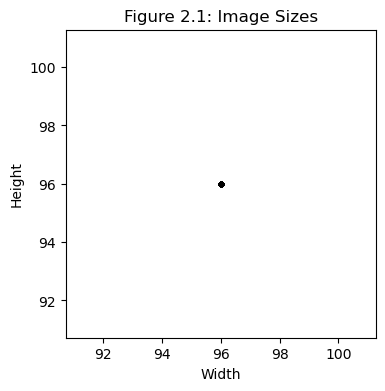

In [ ]:
img_dir = 'train'

# Function to get image dimensions
def get_image_dimensions(img_dir):
    image_dimensions = []
    for filename in os.listdir(img_dir):
        if filename.endswith('.tif'):
            img_path = os.path.join(img_dir, filename)
            with Image.open(img_path) as img:
                width, height = img.size
                image_dimensions.append((width, height))
    return image_dimensions

# Get dimensions of all images
all_image_dimensions = get_image_dimensions(img_dir)

# Separate width and height for plotting
widths = [dim[0] for dim in all_image_dimensions]
heights = [dim[1] for dim in all_image_dimensions]

#sns.set(style = "whitegrid")
# Plot the image sizes
plt.figure(figsize=(4, 4))
plt.scatter(widths, heights, marker='.', color='black', alpha=0.5)
plt.title('Figure 2.1: Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
# Initialize variables to hold min and max pixel values
overall_min_pixel_value = float('inf')
overall_max_pixel_value = float('-inf')

# Iterate through all batches in train_dataloader
for batch in tqdm(train_dataloader, desc="Checking pixel value range"):
    images, labels = batch
    images_np = images.numpy()

    # Calculate min and max pixel values in the current batch
    batch_min_pixel_value = np.min(images_np)
    batch_max_pixel_value = np.max(images_np)

    # Update overall min and max pixel values
    overall_min_pixel_value = min(overall_min_pixel_value, batch_min_pixel_value)
    overall_max_pixel_value = max(overall_max_pixel_value, batch_max_pixel_value)

# Print the overall min and max pixel values found across all images
print(f"Overall min pixel value: {overall_min_pixel_value}")
print(f"Overall max pixel value: {overall_max_pixel_value}")

Checking pixel value range: 100%|███████████| 6876/6876 [02:43<00:00, 42.08it/s]

Overall min pixel value: 0.0
Overall max pixel value: 1.0


## 2.3 Size and Class Distribution

There are 220,025 total images in the dataset, of which 89,117 are positive (metastatic), approximately 40.5% of the total images, while 130,908 are negative (non-metastatic), approximately 59.5% of the total images. Note there are no images that do not have a corresponding label.

The following code and Figure 2.2 calculate and who this class distribution.


Total Images: 220025
Positive Images: 89117
Positive Percentage of Images: 40.503124644926714%
Negative Images: 130908
Negative Percentage of Images: 59.496875355073286%


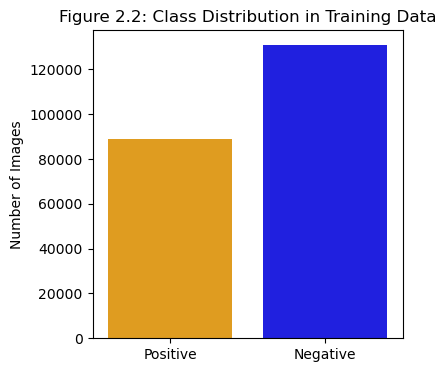

In [ ]:
num_train = len(train_labels)
num_train_pos = train_labels['label'].sum()
num_train_neg = num_train - num_train_pos
percent_train_pos = num_train_pos/num_train * 100
percent_train_neg = num_train_neg/num_train * 100
print(f'Total Images: {num_train}')
print(f'Positive Images: {num_train_pos}')
print(f'Positive Percentage of Images: {percent_train_pos}%')
print(f'Negative Images: {num_train_neg}')
print(f'Negative Percentage of Images: {percent_train_neg}%')

labels = ['Positive', 'Negative']
counts = [num_train_pos, num_train_neg]

plt.figure(figsize=(4, 4))
sns.barplot(x=labels, y=counts, palette=['orange', 'blue'])
plt.title('Figure 2.2: Class Distribution in Training Data')
plt.ylabel('Number of Images')
plt.show()

## 2.4 Pixel Intensity Distribution


The distribution of pixel intensities across images can provide essential insights into the visual characteristics of the dataset. Analyzing pixel intensity distributions by label type (positive for metastatic tissue and negative for non-metastatic tissue) uncovers distinct patterns that may aid in classification. The histograms in Figure 2.3 demonstrate variations in pixel intensities, indicating potential differences in tissue properties such as color composition and contrast. These differences are crucial as they highlight how certain types of tissues or stains appear differently in terms of color intensity, which is captured by individual color channels (Red, Green, Blue).

The following code generates histograms of pixel intensities for each color channel (red, green, and blue):


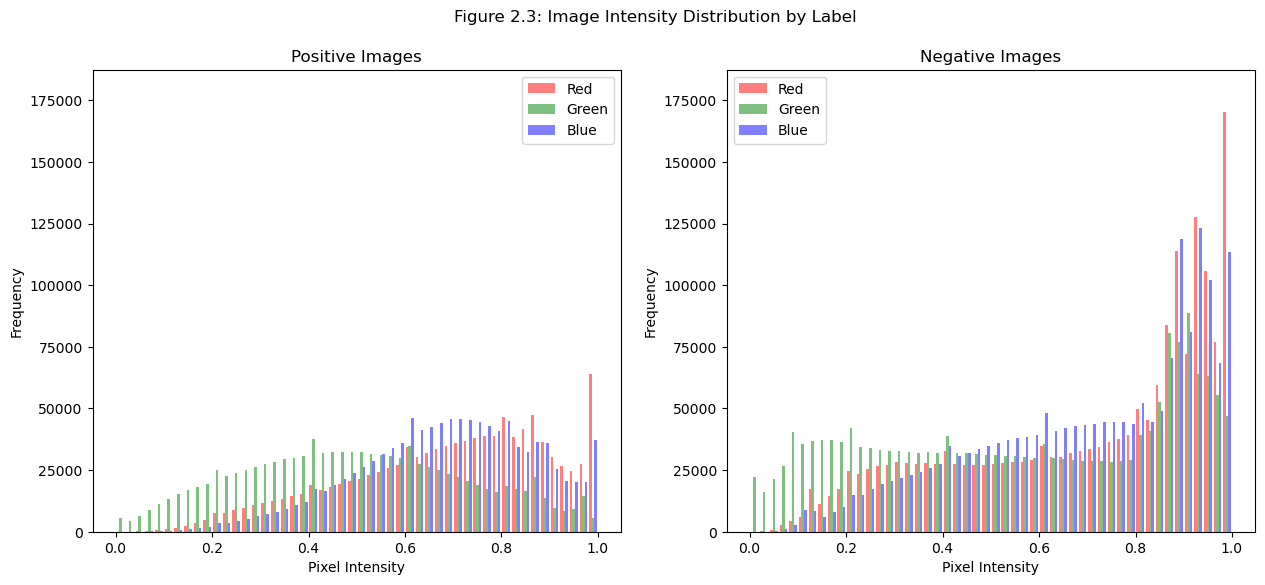

In [ ]:
def plot_image_intensity_distribution_by_label(dataloader, num_batches=1):
    positive_images = []
    negative_images = []

    for i, (images, labels) in enumerate(dataloader):
        for img, label in zip(images, labels):
            if label == 1:
                positive_images.append(img)
            else:
                negative_images.append(img)

        if i >= num_batches - 1:
            break

    if len(positive_images) > 0:
        positive_images = torch.stack(positive_images).numpy()
        positive_images = positive_images.transpose((0, 2, 3, 1)).reshape(-1, 3)

    if len(negative_images) > 0:
        negative_images = torch.stack(negative_images).numpy()
        negative_images = negative_images.transpose((0, 2, 3, 1)).reshape(-1, 3)

    # Calculate histogram separately for positive and negative images
    positive_hist_red, _ = np.histogram(positive_images[..., 0].flatten(), bins=50)
    positive_hist_green, _ = np.histogram(positive_images[..., 1].flatten(), bins=50)
    positive_hist_blue, _ = np.histogram(positive_images[..., 2].flatten(), bins=50)

    negative_hist_red, _ = np.histogram(negative_images[..., 0].flatten(), bins=50)
    negative_hist_green, _ = np.histogram(negative_images[..., 1].flatten(), bins=50)
    negative_hist_blue, _ = np.histogram(negative_images[..., 2].flatten(), bins=50)

    # Find the maximum frequency among all histograms
    max_frequency = max(positive_hist_red.max() if len(positive_images) > 0 else 0,
                        positive_hist_green.max() if len(positive_images) > 0 else 0,
                        positive_hist_blue.max() if len(positive_images) > 0 else 0,
                        negative_hist_red.max() if len(negative_images) > 0 else 0,
                        negative_hist_green.max() if len(negative_images) > 0 else 0,
                        negative_hist_blue.max() if len(negative_images) > 0 else 0)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    if len(positive_images) > 0:
        axes[0].hist(positive_images, bins=50, color=['red', 'green', 'blue'], alpha=0.5, label=['Red', 'Green', 'Blue'])
        axes[0].set_title('Positive Images')
        axes[0].set_xlabel('Pixel Intensity')
        axes[0].set_ylabel('Frequency')
        axes[0].set_ylim(0, max_frequency*1.1)
        axes[0].legend()

    if len(negative_images) > 0:
        axes[1].hist(negative_images, bins=50, color=['red', 'green', 'blue'], alpha=0.5, label=['Red', 'Green', 'Blue'])
        axes[1].set_title('Negative Images')
        axes[1].set_xlabel('Pixel Intensity')
        axes[1].set_ylabel('Frequency')
        axes[1].set_ylim(0, max_frequency*1.1)
        axes[1].legend()

    plt.suptitle('Figure 2.3: Image Intensity Distribution by Label')
    plt.show()

# Plot the image intensity distribution by label
plot_image_intensity_distribution_by_label(train_dataloader, num_batches=10)


## 2.5 Texture Features Distribution

Texture features derived from GLCM analysis, including contrast, dissimilarity, homogeneity, energy, and correlation, provide valuable insights into the underlying textural characteristics of histopathologic images. These features are essential for understanding the microstructural details that may differentiate between metastatic and non-metastatic tissue samples.

### Contrast Distribution

The contrast feature quantifies local intensity variations within the grayscale image. Higher contrast values indicate greater differences in pixel intensities between neighboring pixels. Contrast Distribution in Figure 2.4 illustrates the overlap and separation of contrast histograms for positive (metastatic) and negative (non-metastatic) labels. A significant separation between the distributions suggests that contrast could serve as a discriminative feature for distinguishing between the two classes.

### Dissimilarity Distribution

Dissimilarity measures pixel-wise differences within the image. Higher dissimilarity values indicate greater discrepancies between adjacent pixel pairs. Dissimilarity Distribution in Figure 2.4 examines the dissimilarity distributions for positive and negative labels, highlighting potential discriminative power based on the observed separation between the histograms.

### Homogeneity Distribution

Homogeneity assesses the uniformity of pixel pairs in terms of intensity. Higher homogeneity values indicate more consistent pixel relationships. Homogeneity Distribution in Figure 2.4 compares homogeneity distributions across positive and negative labels, indicating differences that could aid in classification tasks.

### Energy Distribution

Energy, or Angular Second Moment, quantifies textural uniformity based on the sum of squared elements in the GLCM. Higher energy values suggest lower texture complexity. Energy Distribution in Figure 2.4 evaluates energy distributions, emphasizing distinctions that may contribute to effective feature selection.

### Correlation Distribution

Correlation measures the linear dependence between pixel pairs across the entire image. Higher correlation values indicate stronger pixel relationships. Correlation Distribution in Figure 2.4 analyzes correlation distributions for positive and negative labels, highlighting potential contributions to classification accuracy.

The degree of overlap and separation observed in these texture feature histograms provides insights into their discriminatory potential. Features with clear separations between positive and negative distributions, such as contrast and dissimilarity, are likely more informative for distinguishing between tissue types. Conversely, if histograms show significant overlap, additional features or methods may be necessary to enhance classification performance.

The code below calculates these features and plots the histograms:


In [ ]:
%%capture
# Suppress warnings
warnings.filterwarnings("ignore")

def compute_texture_features(image):
    # Convert the image to an unsigned integer type
    image_uint8 = img_as_ubyte(np.array(image))

    # Check if the image is grayscale
    if image_uint8.ndim == 2:  # Image is already grayscale
        image_gray = image_uint8
    elif image_uint8.ndim == 3:  # Convert RGB to grayscale
        # Transpose the dimensions to match the expected shape for rgb2gray
        image_rgb = np.transpose(image_uint8, (1, 2, 0))
        image_gray = rgb2gray(image_rgb)
    else:
        raise ValueError("Unsupported image format")

    # Ensure the image is in the correct range
    image_gray = (image_gray * 255).astype(np.uint8)

    # Compute the GLCM
    distances = [1]  # Distance between pixel pairs
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles for which GLCM is computed
    glcm = greycomatrix(image_gray, distances=distances, angles=angles, symmetric=True, normed=True)

    # Compute texture features from GLCM
    contrast = greycoprops(glcm, 'contrast').flatten().mean()
    dissimilarity = greycoprops(glcm, 'dissimilarity').flatten().mean()
    homogeneity = greycoprops(glcm, 'homogeneity').flatten().mean()
    energy = greycoprops(glcm, 'energy').flatten().mean()
    correlation = greycoprops(glcm, 'correlation').flatten().mean()

    return contrast, dissimilarity, homogeneity, energy, correlation


# Suppress warnings
warnings.filterwarnings("ignore")

# Compute texture features for each image in train_dataset
texture_features = []
for i in range(len(train_dataset)):
    # Get the corresponding id from the train_labels DataFrame
    image_id = train_labels.iloc[i]["id"]

    # Get the image from train_dataset
    image, label = train_dataset[i]

    # Compute texture features for the image
    contrast, dissimilarity, homogeneity, energy, correlation = compute_texture_features(image)
    texture_features.append([image_id, contrast, dissimilarity, homogeneity, energy, correlation])

warnings.resetwarnings()

In [ ]:
train_texture = pd.DataFrame(texture_features, columns=["id", "contrast", "dissimilarity", "homogeneity", "energy", "correlation"])
train_texture = pd.merge(train_labels[['id', 'label']], train_texture, on='id')
print(train_texture.head())

                                         id  label     contrast  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   766.170399   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   892.004408   
2  755db6279dae599ebb4d39a9123cce439965282d      0  3028.138273   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   799.435639   
4  068aba587a4950175d04c680d38943fd488d6a9d      0  2578.635393   

   dissimilarity  homogeneity    energy  correlation  
0      11.794174     0.451138  0.176040     0.717861  
1      15.937200     0.180458  0.046906     0.812137  
2      40.773434     0.029575  0.009633     0.536408  
3      19.735806     0.134803  0.050822     0.825783  
4      37.867424     0.032175  0.010097     0.549030  


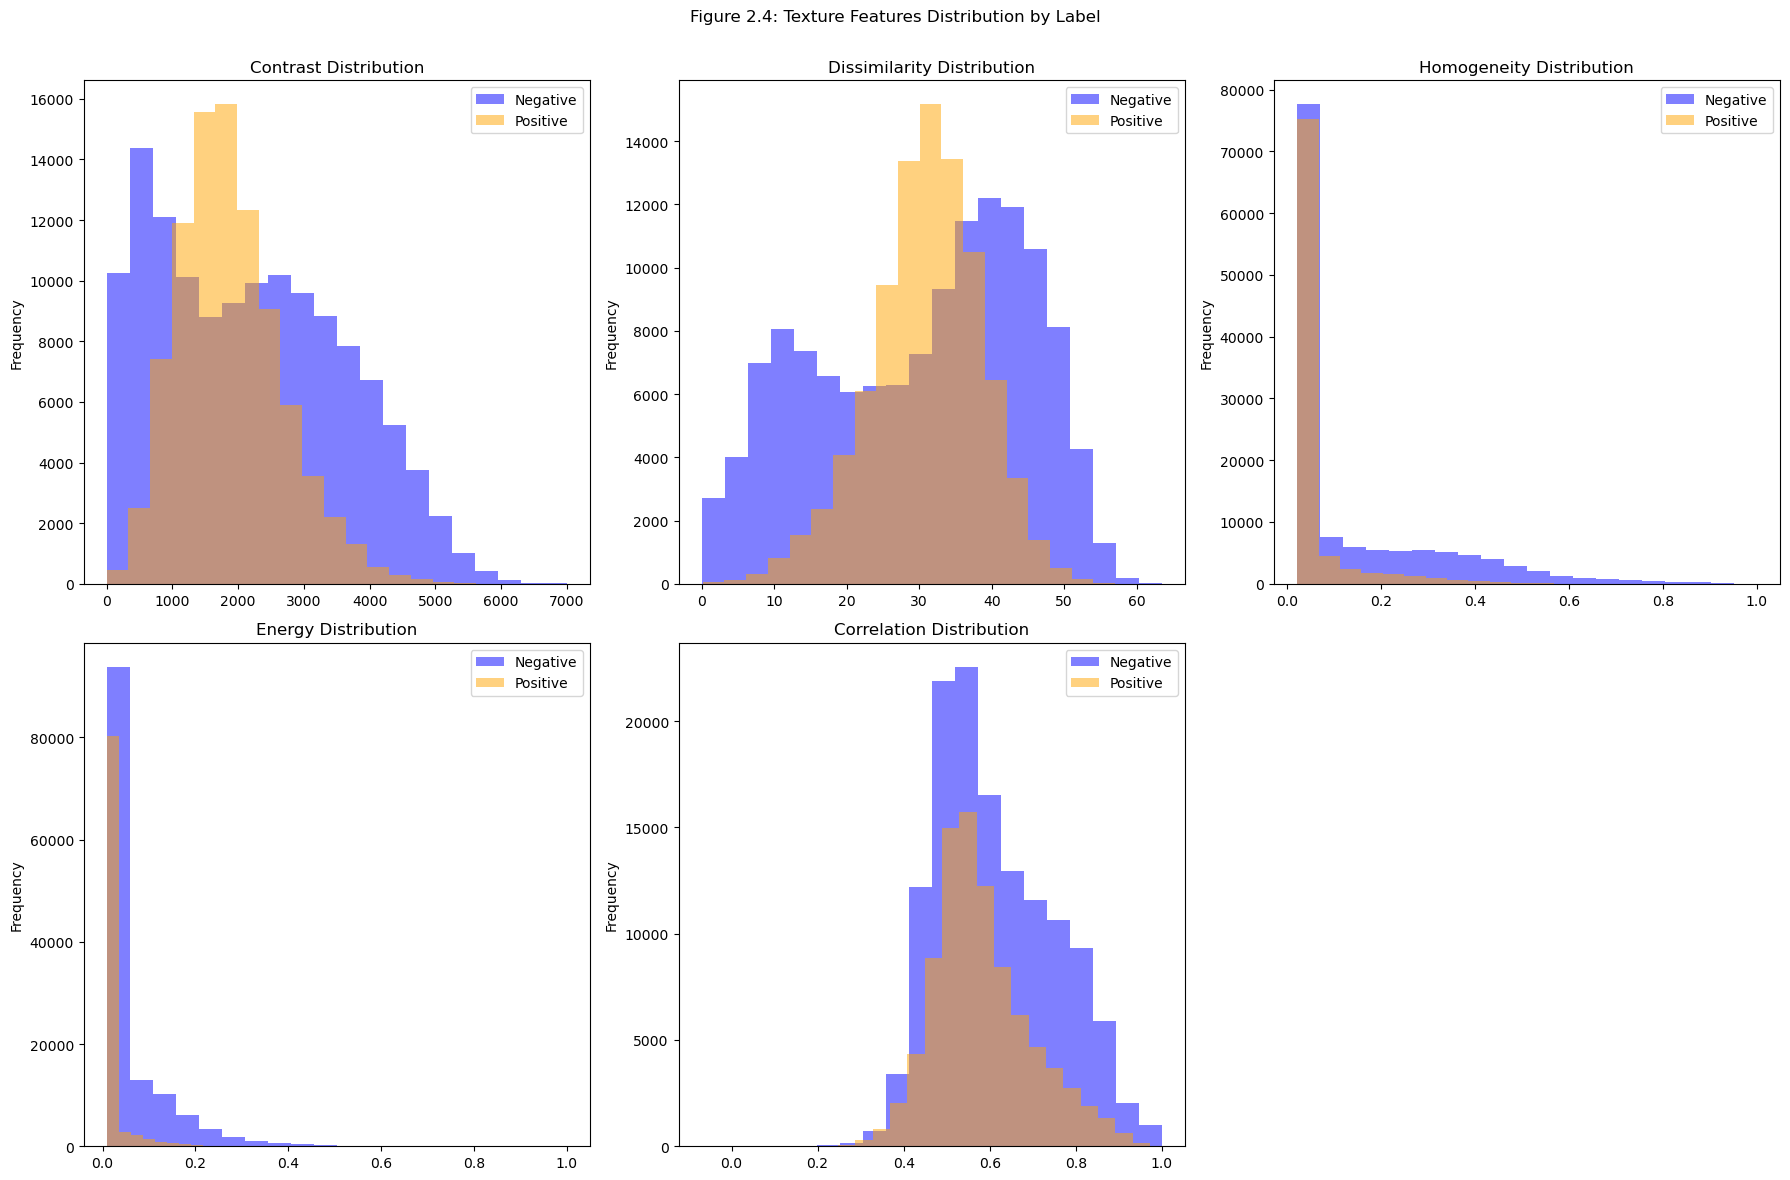

In [ ]:
# Create subplots with two columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Texture features
features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

# Plot histograms for each feature
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3

    # Plot positive and negative labels
    train_texture[train_texture['label'] == 0][feature].plot.hist(ax=axes[row, col], color='blue', alpha=0.5, bins=20, label='Negative')
    train_texture[train_texture['label'] == 1][feature].plot.hist(ax=axes[row, col], color='orange', alpha=0.5, bins=20, label='Positive')

    # Set titles and labels
    axes[row, col].set_title(f'{feature.capitalize()} Distribution')
    axes[row, col].set_ylabel('Frequency')

    # Add legend
    axes[row, col].legend()

# Hide the sixth empty subplot if the number of features is less than 6
if len(features) < 6:
    for ax in axes.flat[len(features):]:
        ax.remove()

# Add the super title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Figure 2.4: Texture Features Distribution by Label', fontsize=12)
plt.show()


# 3 Model Building

## 3.1 Preparing Data for Models

### Class Balancing

To address class imbalance in the dataset, the number of samples in each class (positive and negative) is balanced. The positive class contains significantly fewer samples than the negative class, which could bias the model during training. The balancing approach involves downsampling the negative samples to match the number of positive samples, ensuring equal representation in the training dataset.


In [ ]:
# Separate positive and negative samples
positive_samples = train_labels[train_labels['label'] == 1]
negative_samples = train_labels[train_labels['label'] == 0]

# Downsample the negative samples to match the count of positive samples
downsampled_negative_samples = negative_samples.sample(n=len(positive_samples), random_state=42)

# Combine the positive samples with the downsampled negative samples
balanced_train_labels = pd.concat([positive_samples, downsampled_negative_samples]).reset_index(drop=True)

# Shuffle the combined dataset
balanced_train_labels = balanced_train_labels.sample(frac=1, random_state=42).reset_index(drop=True)

# Save or print the new class distribution to verify
print("New Balanced Class Distribution:")
num_train = len(balanced_train_labels)
num_train_pos = balanced_train_labels['label'].sum()
num_train_neg = num_train - num_train_pos
percent_train_pos = num_train_pos/num_train * 100
percent_train_neg = num_train_neg/num_train * 100
print(f'Total Images: {num_train}')
print(f'Positive Images: {num_train_pos}')
print(f'Positive Percentage of Images: {percent_train_pos}%')
print(f'Negative Images: {num_train_neg}')
print(f'Negative Percentage of Images: {percent_train_neg}%')

New Balanced Class Distribution:
Total Images: 178234
Positive Images: 89117
Positive Percentage of Images: 50.0%
Negative Images: 89117
Negative Percentage of Images: 50.0%


### Split into Training and Validation Sets

The balanced dataset is further divided into training and validation sets, with 20% of the data reserved for validation. Class distributions are checked again to ensure consistent balance in both subsets.


In [ ]:
# Split the dataset into training and validation sets
train_labels, val_labels = train_test_split(balanced_train_labels, test_size=0.2, random_state=42)
print("New Training Class Distribution:")
num_train = len(train_labels)
num_train_pos = train_labels['label'].sum()
num_train_neg = num_train - num_train_pos
percent_train_pos = num_train_pos/num_train * 100
percent_train_neg = num_train_neg/num_train * 100
print(f'Total Images: {num_train}')
print(f'Positive Images: {num_train_pos}')
print(f'Positive Percentage of Images: {percent_train_pos}%')
print(f'Negative Images: {num_train_neg}')
print(f'Negative Percentage of Images: {percent_train_neg}%')

New Training Class Distribution:
Total Images: 142587
Positive Images: 71273
Positive Percentage of Images: 49.98562281273889%
Negative Images: 71314
Negative Percentage of Images: 50.014377187261104%


### Crop and Resize

Training images only are center-cropped to a fixed size of 64x64 pixels. This step is based on the dataset information, which indicates that the cancerous indicator (a critical feature for classification) is generally located in the center of the image. By cropping the central region, we ensure that the model focuses on the most relevant part of the image. This approach can help the model more effectively identify the cancerous regions, potentially improving classification accuracy.

Additionally, the cropping step reduces the number of pixels the model needs to process, which can lead to faster training times and lower memory usage. With the central crop, we discard irrelevant background information, making the model's training more efficient while still capturing the essential features of the image.

After cropping (only for the training dataset), all images—including those in the training, validation, and test datasets—are resized to 224x224 pixels. This resizing is crucial for two reasons:

- Consistency for Model Input: Many deep learning models, including VGG16 and ResNet50, require images to be of a specific size, typically 224x224 pixels. By resizing the images, we ensure that they match the expected input size of these models.

- Optimal Size for Model Performance: Resizing the images to 224x224 ensures that the model receives an appropriate level of detail without unnecessarily high resolution, which could increase computational costs. The 224x224 size provides a balance between maintaining sufficient resolution for the model to identify important features and keeping the image size manageable for efficient processing.

### Normalization

Normalization is critical to standardize the pixel values across the dataset. The process involves calculating the mean and standard deviation for each color channel (R, G, B) using the training set and applying these values to normalize all datasets. This ensures consistent data scaling, which helps the model converge during training.

### Augmentation

In order to increase the dataset diversity and prevent overfitting, data augmentation is applied. The augmentations include random rotations, horizontal flips, and moderate color jittering. These augmentations help the model become more robust to variations that it might encounter in real-world scenarios.

Random rotations and horizontal flips help the model learn invariant features regardless of the orientation of the cells and tissues. By randomly rotating and flipping the images, the different angles at which histopathological slides might be viewed are simulated, ensuring the model doesn't become biased towards any particular orientation.

Color is an important feature of histopathological images as it helps to differentiate various tissue types, cellular structures, and pathological features. To maintain the integrity of these crucial color features while still introducing some variability, a moderate color jittering is applied. This involves slight changes to brightness, contrast, saturation, and hue, simulating the slight variations that might occur as a result of differences in staining procedures or imaging conditions. The aim is to make the model more robust to these slight variations without significantly altering the fundamental color information that is critical for accurate tissue and pathology identification.

The follow code defines these transformations and applies them:

In [ ]:
# Define the transformations for the training dataset (used only for normalization calculation)
train_transform_for_norm_calc = transforms.Compose([
    transforms.CenterCrop(64),         # Center crop to 64x64 for augmentation
    transforms.Resize((224, 224)),     # Resize to 224x224
    transforms.ToTensor(),
])

# Create a DataLoader for the training dataset to calculate normalization statistics
train_dataset_for_norm_calc = HistopathologicDataset(labels=train_labels, img_dir='train', transform=train_transform_for_norm_calc)
train_dataloader_for_norm_calc = DataLoader(train_dataset_for_norm_calc, batch_size=32, shuffle=True)

# Calculate normalization statistics (mean and std)
def calculate_channel_statistics(dataloader):
    channel_sum = np.zeros(3)
    channel_squared_sum = np.zeros(3)
    num_pixels = 0

    for images, _ in tqdm(dataloader):
        images = images.numpy()  # Convert images to numpy for easier processing
        images = images.transpose((0, 2, 3, 1)).reshape(-1, 3)  # Reshape to (N * H * W, C)

        # Update sums and squared sums
        channel_sum += images.sum(axis=0)
        channel_squared_sum += (images ** 2).sum(axis=0)
        num_pixels += images.shape[0]

    # Calculate mean and std
    mean = channel_sum / num_pixels
    std = np.sqrt(channel_squared_sum / num_pixels - mean ** 2)

    print("Calculated Mean (R, G, B):", mean)
    print("Calculated Std Dev (R, G, B):", std)

    return mean, std

# Call the function to calculate mean and std using the DataLoader
mean, std = calculate_channel_statistics(train_dataloader_for_norm_calc)

100%|██████████| 4456/4456 [08:58<00:00,  8.28it/s]

Calculated Mean (R, G, B): [0.70067292 0.53905101 0.69424722]
Calculated Std Dev (R, G, B): [0.21878676 0.26047965 0.19580003]


In [ ]:
# Define the transformation for the training dataset that includes normalization
train_transform_with_normalization = transforms.Compose([
    transforms.CenterCrop(64),          # Center crop to 64x64 for augmentation
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.ToTensor(),              # Convert image to Tensor
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    transforms.Normalize(mean=mean, std=std),  # Normalize using the calculated mean and std
])

# Update the training dataset with the new transformation that includes normalization
train_dataset = HistopathologicDataset(labels=train_labels, img_dir='train', transform=train_transform_with_normalization)

# Create DataLoader for the updated training dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
# Define the transformations for the validation dataset
val_transform_with_normalization = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.ToTensor(),              # Convert image to Tensor
    transforms.Normalize(mean=mean, std=std),  # Apply the same normalization
])

# Define the transformations for the test dataset
test_transform_with_normalization = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.ToTensor(),              # Convert image to Tensor
    transforms.Normalize(mean=mean, std=std),  # Apply the same normalization
])

# Create DataLoaders for the validation and test datasets
val_dataset = HistopathologicDataset(labels=val_labels, img_dir='train', transform=val_transform_with_normalization)
test_dataset = HistopathologicDataset(labels=test_labels, img_dir='test', transform=test_transform_with_normalization)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Visual Inspection of Augmented Data

To verify the augmentation process, a sample of original and augmented images is visualized. This comparison helps confirm the integrity of the transformations and ensures the augmented images maintain key features necessary for accurate classification.

A grid of images is displayed, where the first row shows the original images, and the second row shows their augmented counterparts. The visual inspection aids in validating that the augmentations align with the intended goals of the preprocessing pipeline.

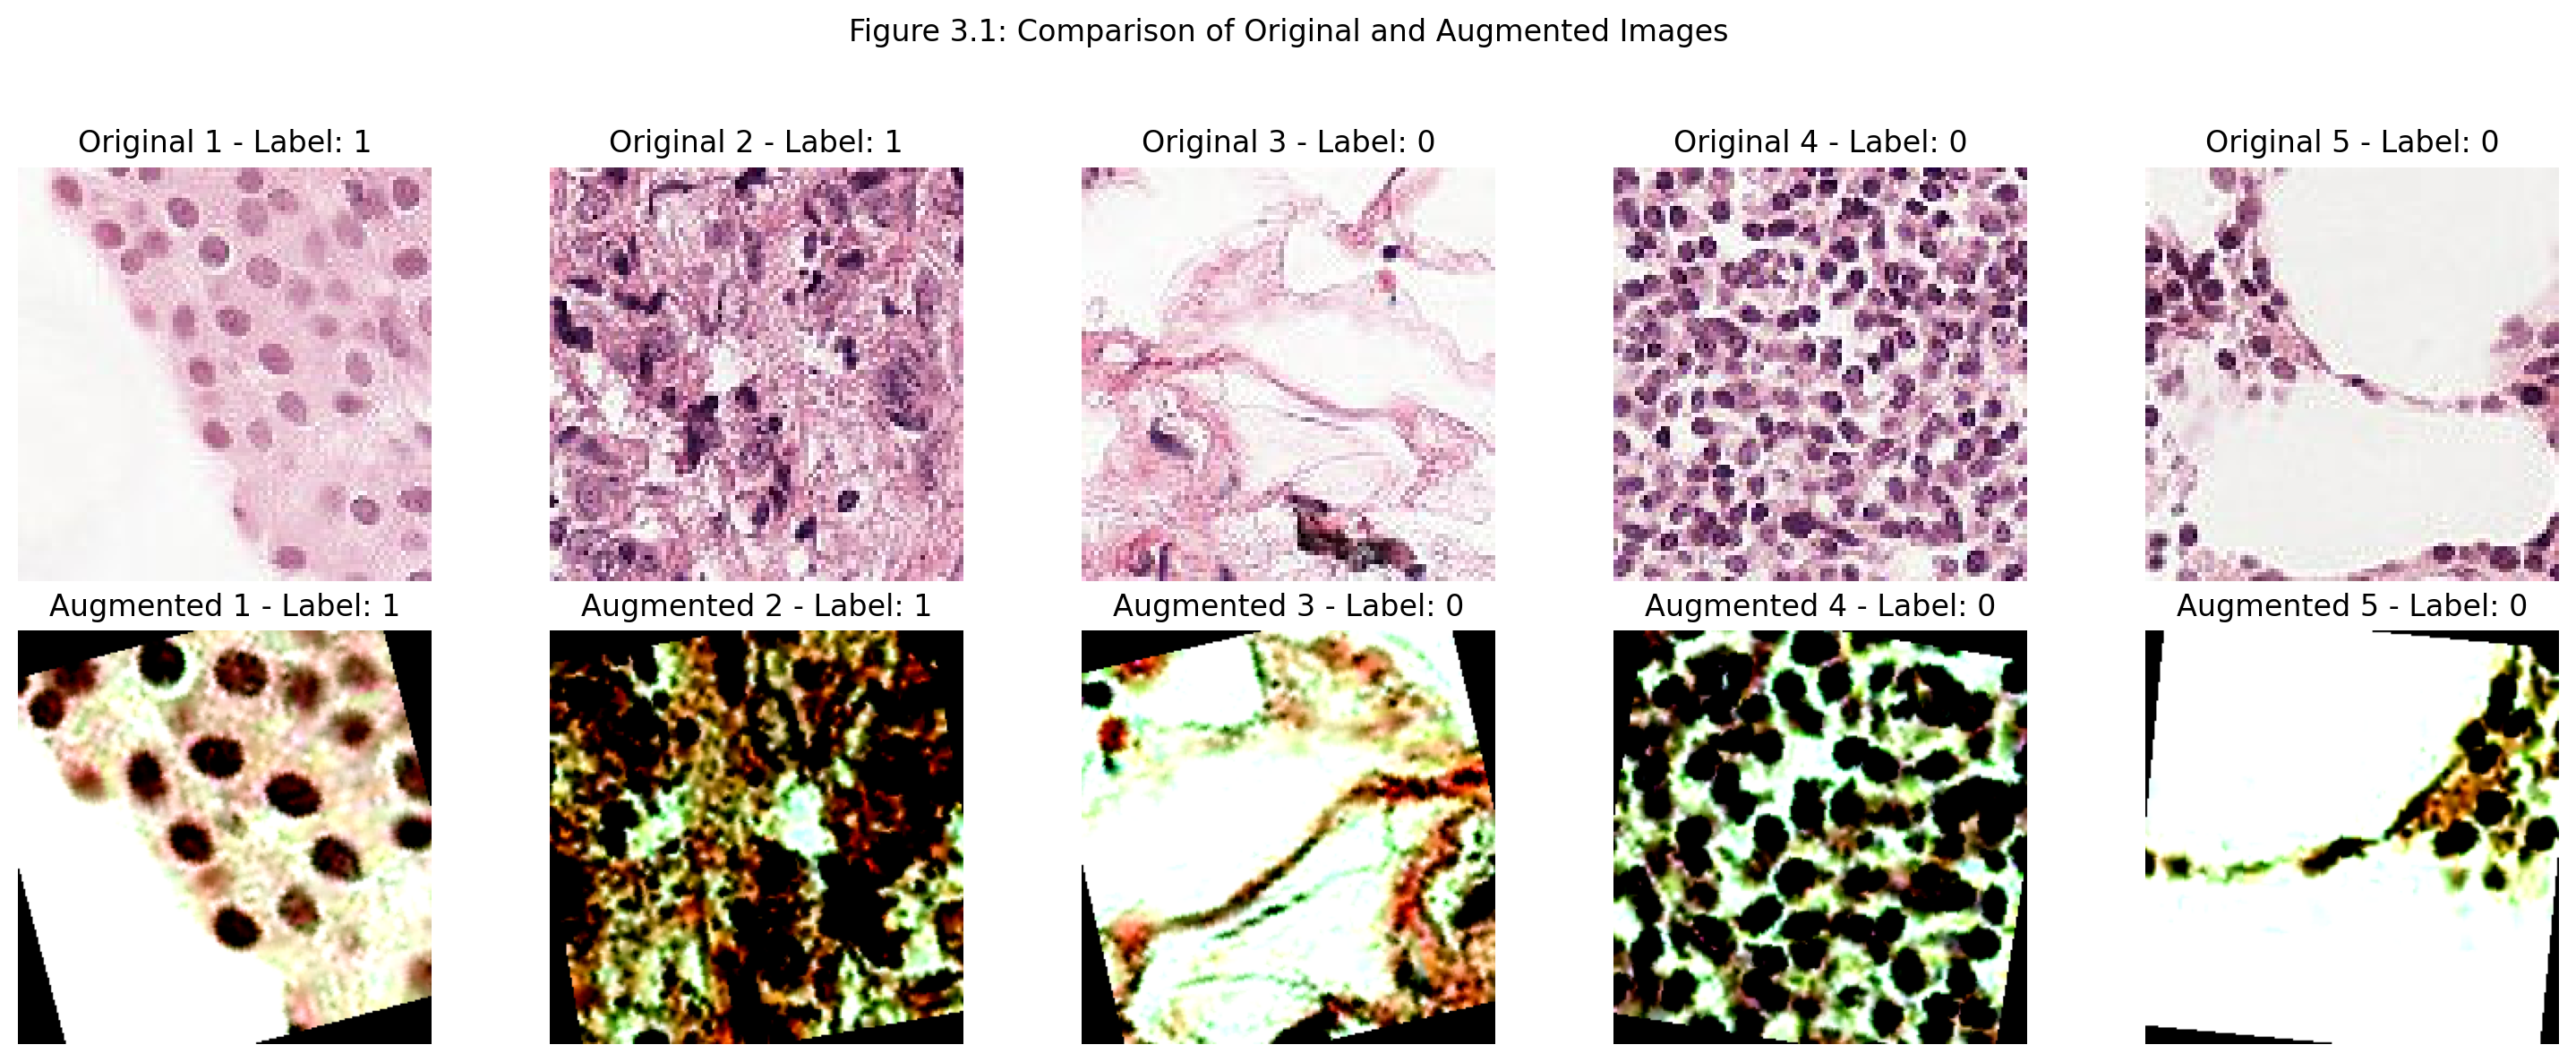

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Save the current warning filters
original_filters = warnings.filters[:]
# Suppress deprecation warnings
warnings.filterwarnings("ignore")

# Parameters
sample_size = 5  # Number of samples to preview

# Apply the same normalization to the original dataset transform for consistency
original_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the original dataset with no transformations (just converting to tensor)
original_dataset = HistopathologicDataset(labels=balanced_train_labels, img_dir='train', transform=original_transform)
original_loader = DataLoader(original_dataset, batch_size=32, shuffle=False)

# For preview samples (to visualize normalization in action)
# The same sample size will be used for both original and augmented datasets
preview_original_dataset = HistopathologicDataset(labels=train_labels.head(sample_size), img_dir='train', transform=original_transform)
preview_augmented_dataset = HistopathologicDataset(labels=train_labels.head(sample_size), img_dir='train', transform=train_transform_with_normalization)
preview_original_loader = DataLoader(preview_original_dataset, batch_size=sample_size, shuffle=False)
preview_augmented_loader = DataLoader(preview_augmented_dataset, batch_size=sample_size, shuffle=False)

# Helper function to display an image with its label
def imshow(ax, img, title=None, label=None):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    if title is not None:
        ax.set_title(f'{title} - Label: {label}')
    ax.axis('off')

# Get a batch of images and labels from both datasets for preview
original_images, original_labels = next(iter(preview_original_loader))
augmented_images, augmented_labels = next(iter(preview_augmented_loader))

# Create figure to compare original and augmented images
fig, axes = plt.subplots(nrows=2, ncols=sample_size, figsize=(sample_size * 3, 6))
fig.suptitle('Figure 3.1: Comparison of Original and Augmented Images', fontsize=12)

# Display images in rows: first row for original, second row for augmented
for i in range(sample_size):
    # Display original image in the first row with its label
    imshow(axes[0, i], original_images[i], title=f'Original {i+1}', label=f'{original_labels[i]}')

    # Display augmented image in the second row with its label
    imshow(axes[1, i], augmented_images[i], title=f'Augmented {i+1}', label=f'{augmented_labels[i]}')

# Adjust layout and display the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Restore the original warning filters
warnings.filters = original_filters


## 3.2 CNN Models

Convolutional Neural Networks (CNNs) are an ideal choice for classifying histopathologic images because they excel at identifying patterns and hierarchical features in image data. By leveraging convolutional layers to detect low-level features like edges and textures, and deeper layers to capture more complex patterns like shapes and structures, CNNs are well-suited for tasks that require spatial feature extraction, such as distinguishing between pathological and normal tissue.

Model Architectures and Shared Hyperparameters
Both CNN models used in this study share a similar architecture designed to effectively process and classify the image data. The models consist of three convolutional layers, each followed by a ReLU activation function and MaxPooling to reduce the spatial dimensions while preserving important features. After the convolutional layers, a fully connected section is used to process the extracted features and map them to class probabilities. Dropout layers are included to reduce overfitting by randomly deactivating neurons during training. The final layer uses a softmax activation function for binary classification.

To ensure a fair comparison, we use the same hyperparameters for both models. These include varying dropout rates ([0.4, 0.6, 0.8]) and learning rates ([0.01, 0.001]) during training. Consistent hyperparameter tuning allows us to assess the impact of the optimizer on model performance without introducing confounding variables.

Differences Between the Two Models
The primary difference between the two models lies in their optimization algorithms:

CNN Adam Model: This model uses the Adam optimizer, which combines momentum and adaptive learning rates. Adam adjusts the learning rate dynamically for each parameter, enabling faster convergence and potentially better performance on complex datasets.

CNN SGD Model: This model employs Stochastic Gradient Descent (SGD) with a fixed learning rate and momentum. While slower than Adam, SGD can sometimes lead to better generalization because of its simpler, more uniform parameter updates.
By comparing these models, we aim to evaluate how the choice of optimizer impacts performance on this specific image classification task, given the same architecture and hyperparameter settings.

### 3.2.1 CNN Adam Model


In [ ]:
# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device to confirm
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Define the CNNAdam1 model
class CNNAdam1(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(CNNAdam1, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce spatial dimensions by half

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce spatial dimensions by half

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce spatial dimensions by half
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Parameters
num_classes = 2
dropout_rates = [0.4, 0.6, 0.8]
learning_rates = [0.001, 0.01]
num_epochs = 10
patience = 5

# List to hold trained models
trained_models = []

# Training and Validation function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect predictions
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        print(f"Training Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

    model.load_state_dict(best_model_wts)
    return model

# Loop through all combinations of dropout rates and learning rates
for dropout_rate in dropout_rates:
    for learning_rate in learning_rates:
        # Instantiate the model with the current dropout rate
        model = CNNAdam1(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

        # Define the loss function and optimizer for the current model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Print model parameters for reference
        print(f"\nTraining model with dropout {dropout_rate} and learning rate {learning_rate}")

        # Train the model
        trained_model = train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience)

        # Store the trained model and its configuration
        trained_models.append({
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "model": trained_model
        })


Training model with dropout 0.4 and learning rate 0.001
Epoch 1/10
Training Loss: 0.4545, Accuracy: 0.7970
Validation Loss: 0.4770, Accuracy: 0.7744
Epoch 2/10
Training Loss: 0.4124, Accuracy: 0.8189
Validation Loss: 0.4354, Accuracy: 0.8054
Epoch 3/10
Training Loss: 0.3986, Accuracy: 0.8257
Validation Loss: 0.3827, Accuracy: 0.8302
Epoch 4/10
Training Loss: 0.3893, Accuracy: 0.8303
Validation Loss: 0.4021, Accuracy: 0.8117
Epoch 5/10
Training Loss: 0.3838, Accuracy: 0.8328
Validation Loss: 0.4442, Accuracy: 0.7929
Epoch 6/10
Training Loss: 0.3794, Accuracy: 0.8349
Validation Loss: 0.4211, Accuracy: 0.8026
Epoch 7/10
Training Loss: 0.3779, Accuracy: 0.8369
Validation Loss: 0.4161, Accuracy: 0.8043
Epoch 8/10
Training Loss: 0.3726, Accuracy: 0.8384
Validation Loss: 0.4141, Accuracy: 0.8138
Early stopping triggered!

Training model with dropout 0.4 and learning rate 0.01
Epoch 1/10
Training Loss: 1.1782, Accuracy: 0.5010
Validation Loss: 0.6934, Accuracy: 0.4994
Epoch 2/10
Training Loss:

### 3.2.2 CNN SVG Model

In [ ]:
# Define the CNNSGD1 model
class CNNSGD1(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(CNNSGD1, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce spatial dimensions by half

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce spatial dimensions by half

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce spatial dimensions by half
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Parameters
num_classes = 2
dropout_rates = [0.4, 0.6, 0.8]
learning_rates = [0.001, 0.01]
num_epochs = 10
patience = 5

# List to hold trained models
trained_models = []

# Training and Validation function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect predictions
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        print(f"Training Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    print("-" * 20)
    model.load_state_dict(best_model_wts)
    return model

# Loop through all combinations of dropout rates and learning rates
for dropout_rate in dropout_rates:
    for learning_rate in learning_rates:
        # Instantiate the model with the current dropout rate
        model = CNNSGD1(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

        # Define the loss function and optimizer for the current model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Print model parameters for reference
        print(f"\nTraining model with dropout {dropout_rate} and learning rate {learning_rate}")

        # Train the model
        trained_model = train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience)

        # Store the trained model and its configuration
        trained_models.append({
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "model": trained_model
        })


Training model with dropout 0.4 and learning rate 0.001
Epoch 1/10
Training Loss: 0.5383, Accuracy: 0.7382
Validation Loss: 0.5882, Accuracy: 0.6972
Epoch 2/10
Training Loss: 0.4691, Accuracy: 0.7831
Validation Loss: 0.5169, Accuracy: 0.7559
Epoch 3/10
Training Loss: 0.4507, Accuracy: 0.7944
Validation Loss: 0.5359, Accuracy: 0.7506
Epoch 4/10
Training Loss: 0.4410, Accuracy: 0.8004
Validation Loss: 0.5083, Accuracy: 0.7642
Epoch 5/10
Training Loss: 0.4343, Accuracy: 0.8047
Validation Loss: 0.4426, Accuracy: 0.7984
Epoch 6/10
Training Loss: 0.4286, Accuracy: 0.8072
Validation Loss: 0.4545, Accuracy: 0.7981
Epoch 7/10
Training Loss: 0.4221, Accuracy: 0.8112
Validation Loss: 0.4563, Accuracy: 0.7913
Epoch 8/10
Training Loss: 0.4179, Accuracy: 0.8136
Validation Loss: 0.5025, Accuracy: 0.7649
Epoch 9/10
Training Loss: 0.4133, Accuracy: 0.8156
Validation Loss: 0.4345, Accuracy: 0.8003
Epoch 10/10
Training Loss: 0.4094, Accuracy: 0.8178
Validation Loss: 0.4602, Accuracy: 0.7801

Training mod

## 3.3 Training Log Comparison

### SVD Optimizer:
Higher dropout (0.6, 0.8) resulted in relatively more stable or improved validation accuracy across epochs, compared to 0.4 dropout.

The validation loss fluctuated across different epochs but generally decreased slightly as the number of epochs increased for the lower learning rate (0.001). Training accuracy tends to improve progressively across epochs, reaching higher levels for the 0.4 dropout and 0.001 learning rate, with around 81-84% at the final epochs.

### Adam Optimizer:
0.4 dropout and 0.001 lr saw better improvements, especially for validation accuracy, with values going from around 77-83% by the final epoch.
The training loss was high in early epochs, especially with 0.01 learning rate, but reduced over time.

The Adam optimizer with 0.01 lr underperformed due to poor convergence early on. Validation accuracy for 0.01 lr remained near 50%, showing little improvement across epochs, possibly due to optimization or data issues.

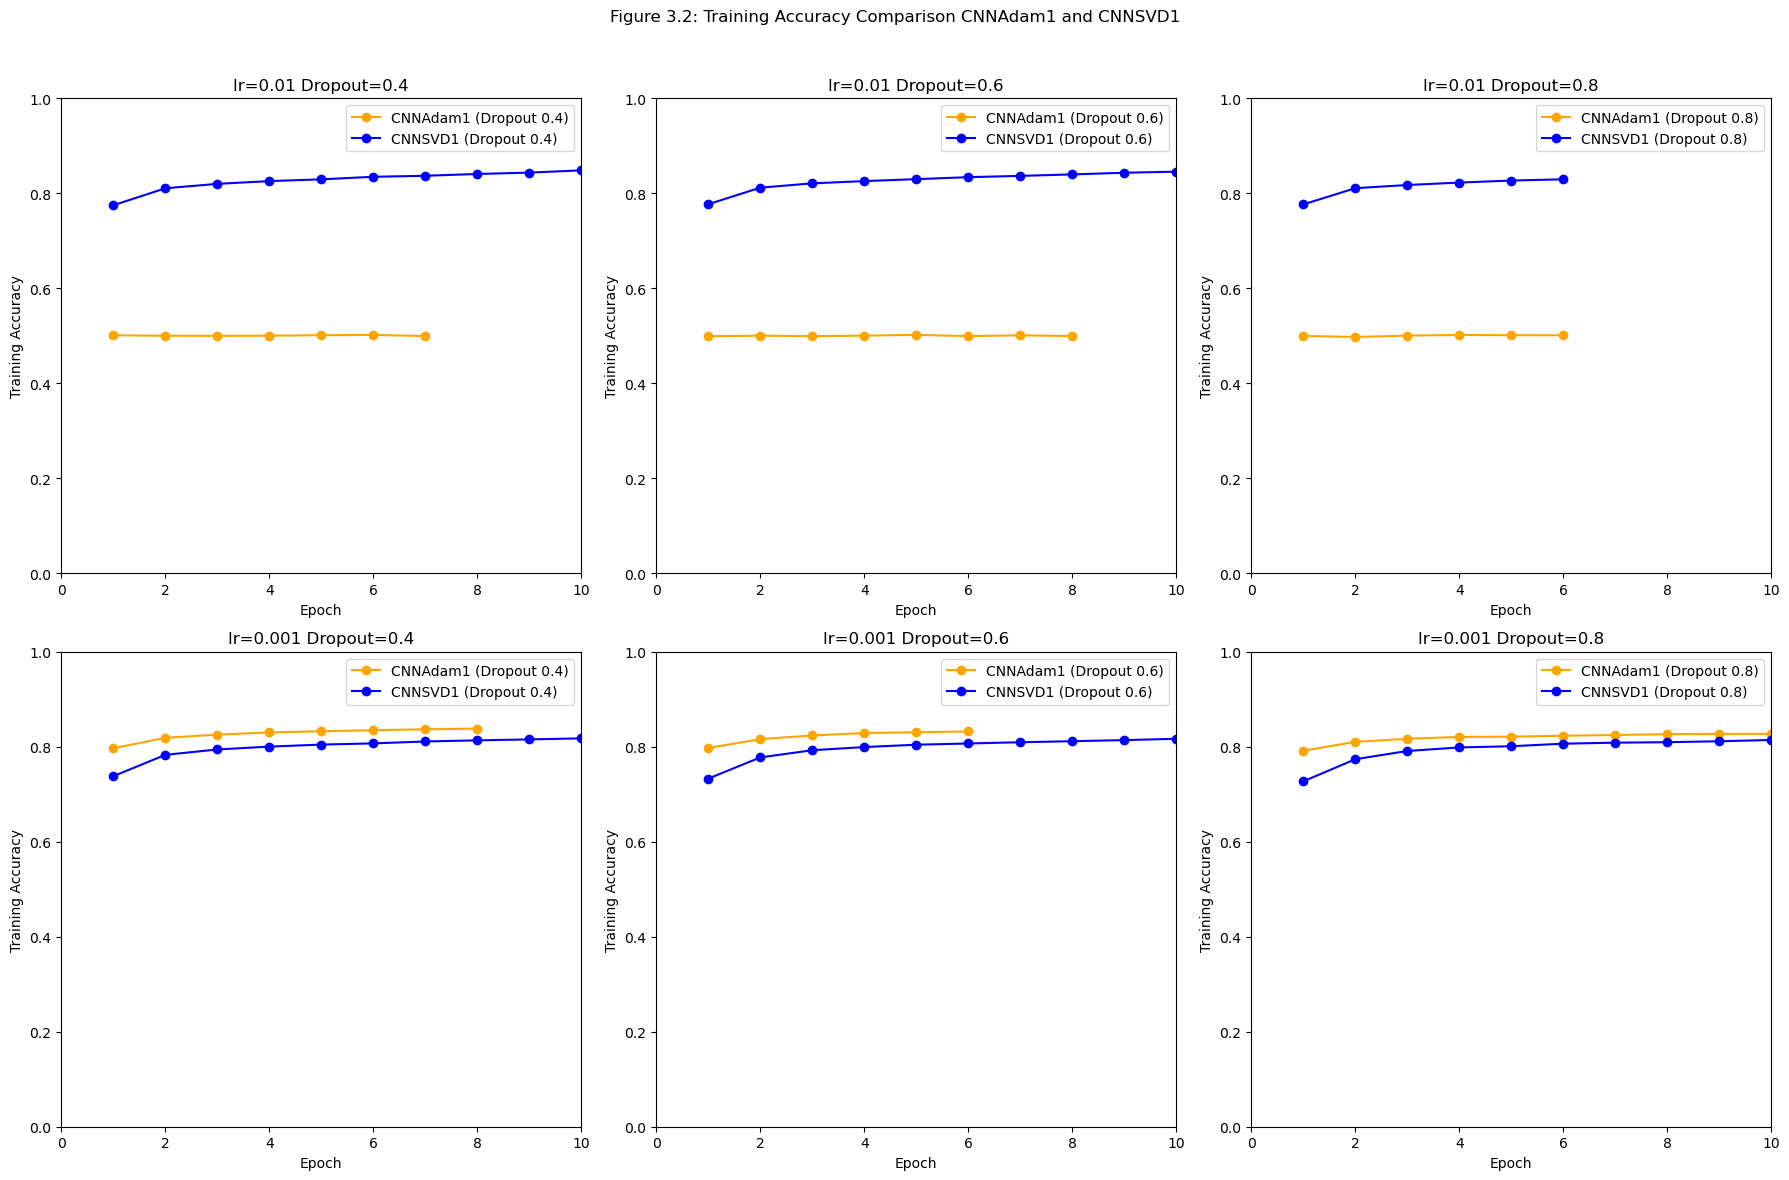

In [ ]:
# Load training logs from CSV files
train_log_cnnadam1 = pd.read_csv('training_log_CNNAdam1.csv')
train_log_cnnsvd1 = pd.read_csv('training_log_CNNSVD1.csv')

# Create a figure with 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Figure 3.2: Training Accuracy Comparison CNNAdam1 and CNNSVD1')

# Define dropout values and learning rates to filter data
dropout_values = [0.4, 0.6, 0.8]
learning_rates = [0.01, 0.001]

# Iterate over dropout values and learning rates to plot
for i, lr in enumerate(learning_rates):
    for j, dropout in enumerate(dropout_values):
        ax = axs[i, j]  # Select subplot
        # Filter data for CNNAdam1 and CNNSVD1
        data_cnnadam1 = train_log_cnnadam1[(train_log_cnnadam1['lr'] == lr) &
                                           (train_log_cnnadam1['dropout'] == dropout)]
        data_cnnsvd1 = train_log_cnnsvd1[(train_log_cnnsvd1['lr'] == lr) &
                                         (train_log_cnnsvd1['dropout'] == dropout)]

        # Plot training accuracy for both models on the same plot
        ax.plot(data_cnnadam1['epoch'], data_cnnadam1['train_acc'], label=f'CNNAdam1 (Dropout {dropout})', color='orange', linestyle='-', marker='o')
        ax.plot(data_cnnsvd1['epoch'], data_cnnsvd1['train_acc'], label=f'CNNSVD1 (Dropout {dropout})', color='blue', linestyle='-', marker='o')

        # Set plot labels and title
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Training Accuracy')
        ax.set_title(f'lr={lr} Dropout={dropout}')
        ax.set_xlim(0, 10)  # Set x-axis (epochs) to 10 for all plots
        ax.set_ylim(0, 1.0)  # Set y-axis to range from 0 to 1.0
        ax.legend()

# Adjust layout to make room for the title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3.4 Model Tuning

The learning rate of 0.001 performed significantly better than other tested values, demonstrating stable convergence and higher validation accuracy. Based on these results, future model tuning will focus on this learning rate as the optimal starting point. This learning rate provided a good balance between training speed and model performance, ensuring that the model could learn effectively without overshooting optimal weights.

Adding a backbone, such as ResNet, is a logical next step for model improvement. The ResNet architecture, with its pre-trained weights, allows the model to leverage learned features from large datasets like ImageNet, which can enhance its ability to generalize to new, unseen data. The inclusion of a backbone is expected to significantly improve feature extraction, especially for more complex tasks, by utilizing the deep residual learning framework of ResNet. This architecture, known for its skip connections, helps to mitigate the vanishing gradient problem, making it effective for training deep networks. By using ResNet, the model can capture more intricate patterns in the data and improve overall classification accuracy, especially when fine-tuned for the specific task at hand.

In [ ]:
# Split the labels into training and validation sets
train_labels, val_labels = train_test_split(balanced_train_labels, test_size=0.2, random_state=42)

# Define the ImageNet mean and std for ResNet
resnet_mean = [0.485, 0.456, 0.406]
resnet_std = [0.229, 0.224, 0.225]

# Define the transformation for the training dataset with ImageNet normalization for ResNet
train_transform_resnet = transforms.Compose([
    transforms.CenterCrop(64),           # Center crop to 64x64 for augmentation
    transforms.Resize((224, 224)),       # Resize to 224x224 (ResNet input size)
    transforms.ToTensor(),               # Convert image to Tensor
    transforms.RandomRotation(degrees=15),  # Random rotation for augmentation
    transforms.RandomHorizontalFlip(),   # Random horizontal flip for augmentation
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),  # Color augmentation
    transforms.Normalize(mean=resnet_mean, std=resnet_std),  # Normalize using ResNet ImageNet values
])

# Update the training dataset with the new transformation for ResNet
train_dataset = HistopathologicDataset(labels=train_labels, img_dir='train', transform=train_transform_resnet)

# Create DataLoader for the updated training dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the transformations for the validation dataset with ImageNet normalization for ResNet
val_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to 224x224 (ResNet input size)
    transforms.ToTensor(),              # Convert image to Tensor
    transforms.Normalize(mean=resnet_mean, std=resnet_std),  # Normalize using ResNet ImageNet values
])

# Define the transformations for the test dataset with ImageNet normalization for ResNet
test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to 224x224 (ResNet input size)
    transforms.ToTensor(),              # Convert image to Tensor
    transforms.Normalize(mean=resnet_mean, std=resnet_std),  # Normalize using ResNet ImageNet values
])

# Create DataLoaders for the validation and test datasets
val_dataset = HistopathologicDataset(labels=val_labels, img_dir='train', transform=val_transform_resnet)
test_dataset = HistopathologicDataset(labels=test_labels, img_dir='test', transform=test_transform_resnet)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 3.4.1 CNNAdam2


In [ ]:
# Define the CNNAdam2 model with a backbone
class CNNAdam2(nn.Module):
    def __init__(self, num_classes, dropout_rate, backbone='resnet18'):
        super(CNNAdam2, self).__init__()

        # Choose the backbone model (ResNet18 as an example)
        if backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # Modify the final fully connected layer to match the number of classes
        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Parameters
num_classes = 2
dropout_rates = [0.4, 0.6, 0.8]
learning_rates = [0.001]
num_epochs = 10
patience = 5

# Mount Google Drive for saving models
drive.mount('/content/drive')

# Directory to save models in Google Drive
model_save_dir = "/content/drive/My Drive/Kaggle_CNN_Histopathology/"

# List to hold trained models
trained_models = []

# Training and Validation function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect predictions
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        print(f"Training Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

    model.load_state_dict(best_model_wts)
    return model

# Loop through all combinations of dropout rates and learning rates
for dropout_rate in dropout_rates:
    for learning_rate in learning_rates:
        # Instantiate the model with the current dropout rate and backbone
        model = CNNAdam2(num_classes=num_classes, dropout_rate=dropout_rate, backbone='resnet18').to(device)

        # Define the loss function and optimizer for the current model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Print model parameters for reference
        print(f"\nTraining model with dropout {dropout_rate} and learning rate {learning_rate}")

        # Train the model
        trained_model = train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience)

        # Store the trained model and its configuration
        trained_models.append({
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "model": trained_model
        })

# Save all trained models
for trained_model_info in trained_models:
    model = trained_model_info["model"]
    dropout_rate = trained_model_info["dropout_rate"]
    learning_rate = trained_model_info["learning_rate"]

    # Save model after training
    model_save_path = f"{model_save_dir}modelCNNAdam2_dropout_{dropout_rate}_lr_{learning_rate}.pth"
    torch.save(model.state_dict(), model_save_path)
    #print(f"Model with dropout {dropout_rate} and learning rate {learning_rate} saved to {model_save_path}")

Training model with dropout 0.4 and learning rate 0.001
Epoch 1/10
Training Loss: 0.3730, Accuracy: 0.8384
Validation Loss: 0.3524, Accuracy: 0.8512
Epoch 2/10
Training Loss: 0.3094, Accuracy: 0.8714
Validation Loss: 0.3066, Accuracy: 0.8716
Epoch 3/10
Training Loss: 0.2828, Accuracy: 0.8846
Validation Loss: 0.4060, Accuracy: 0.8192
Epoch 4/10
Training Loss: 0.2606, Accuracy: 0.8945
Validation Loss: 0.7147, Accuracy: 0.7631
Epoch 5/10
Training Loss: 0.2476, Accuracy: 0.9006
Validation Loss: 0.3906, Accuracy: 0.8561
Epoch 6/10
Training Loss: 0.2372, Accuracy: 0.9059
Validation Loss: 0.5214, Accuracy: 0.8153
Epoch 7/10
Training Loss: 0.2268, Accuracy: 0.9109
Validation Loss: 0.6387, Accuracy: 0.7968
Early stopping triggered!

Training model with dropout 0.6 and learning rate 0.001
Epoch 1/10
Training Loss: 0.3846, Accuracy: 0.8365
Validation Loss: 0.3547, Accuracy: 0.8397
Epoch 2/10
Training Loss: 0.3147, Accuracy: 0.8716
Validation Loss: 0.4080, Accuracy: 0.8247
Epoch 3/10
Training Loss

### 3.4.2 CNNSVD2

In [ ]:
# Define the SVD2 model with a backbone
class SVD2(nn.Module):
    def __init__(self, num_classes, dropout_rate, backbone='resnet18'):
        super(SVD2, self).__init__()

        # Choose the backbone model (ResNet18 as an example)
        if backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # Modify the final fully connected layer to match the number of classes
        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Parameters
num_classes = 2
dropout_rates = [0.4, 0.6, 0.8]
learning_rates = [0.001]
num_epochs = 10
patience = 5

# List to hold trained models
trained_models = []

# Training and Validation function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect predictions
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        print(f"Training Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    print("-" * 20)

    model.load_state_dict(best_model_wts)
    return model

# Testing function
def test_model(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

# Loop through all combinations of dropout rates and learning rates
for dropout_rate in dropout_rates:
    for learning_rate in learning_rates:
        # Instantiate the model with the current dropout rate and backbone
        model = SVD2(num_classes=num_classes, dropout_rate=dropout_rate, backbone='resnet18').to(device)

        # Define the loss function and optimizer for the current model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Print model parameters for reference
        print(f"\nTraining model with dropout {dropout_rate} and learning rate {learning_rate}")

        # Train the model
        trained_model = train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience)

        # Store the trained model and its configuration
        trained_models.append({
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "model": trained_model
        })

# Save all trained models
for trained_model_info in trained_models:
    model = trained_model_info["model"]
    dropout_rate = trained_model_info["dropout_rate"]
    learning_rate = trained_model_info["learning_rate"]

    # Save model after training
    model_save_path = f"{model_save_dir}modelCNNSVD2_dropout_{dropout_rate}_lr_{learning_rate}.pth"
    torch.save(model.state_dict(), model_save_path)
#     print(f"Model with dropout {dropout_rate} and learning rate {learning_rate} saved to {model_save_path}")

Training model with dropout 0.4 and learning rate 0.001
Epoch 1/10
Training Loss: 0.4183, Accuracy: 0.8062
Validation Loss: 0.4069, Accuracy: 0.8130
Epoch 2/10
Training Loss: 0.3317, Accuracy: 0.8570
Validation Loss: 0.4263, Accuracy: 0.8085
Epoch 3/10
Training Loss: 0.3036, Accuracy: 0.8713
Validation Loss: 0.4378, Accuracy: 0.8126
Epoch 4/10
Training Loss: 0.2870, Accuracy: 0.8799
Validation Loss: 0.4350, Accuracy: 0.8135
Epoch 5/10
Training Loss: 0.2734, Accuracy: 0.8867
Validation Loss: 0.4506, Accuracy: 0.8146
Epoch 6/10
Training Loss: 0.2626, Accuracy: 0.8924
Validation Loss: 0.4983, Accuracy: 0.8060
Epoch 7/10
Training Loss: 0.2534, Accuracy: 0.8962
Validation Loss: 0.5335, Accuracy: 0.7939
Epoch 8/10
Training Loss: 0.2456, Accuracy: 0.9003
Validation Loss: 0.5021, Accuracy: 0.8150
Epoch 9/10
Training Loss: 0.2406, Accuracy: 0.9022
Validation Loss: 0.5083, Accuracy: 0.8054
Epoch 10/10
Training Loss: 0.2345, Accuracy: 0.9041
Validation Loss: 0.5601, Accuracy: 0.7989

Training mod

# 4 Results

## 4.1 Validation Accuracy Comparison

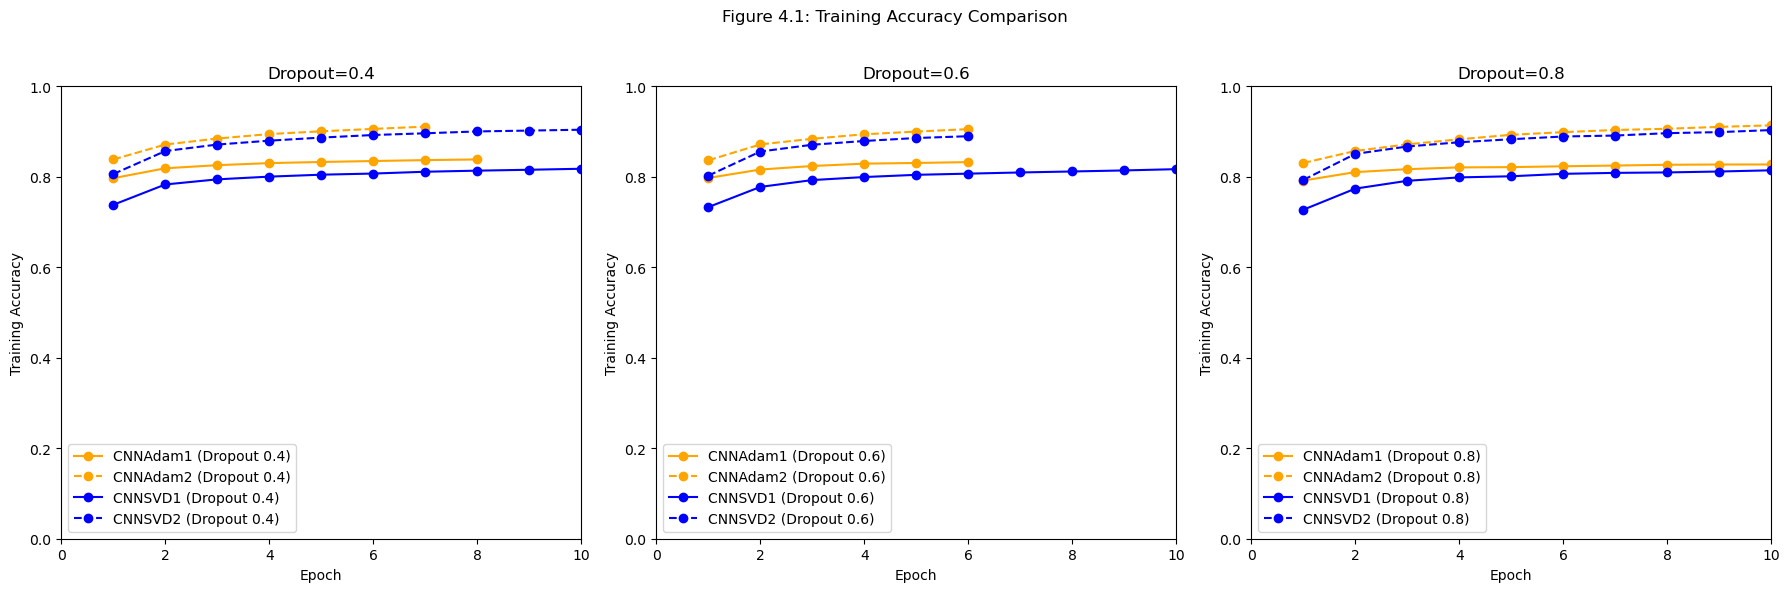

In [ ]:
# Load training logs from CSV files
train_log_cnnadam1 = pd.read_csv('training_log_CNNAdam1.csv')
train_log_cnnadam2 = pd.read_csv('training_log_CNNAdam2.csv')
train_log_cnnsvd1 = pd.read_csv('training_log_CNNSVD1.csv')
train_log_cnnsvd2 = pd.read_csv('training_log_CNNSVD2.csv')

# Create a figure with 3 subplots (one for each dropout rate)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Figure 4.1: Training Accuracy Comparison')

# Define dropout values to filter data
dropout_values = [0.4, 0.6, 0.8]

# Iterate over dropout values to plot on the corresponding subplot
for i, dropout in enumerate(dropout_values):
    ax = axs[i]  # Select subplot for current dropout value

    # List of models to plot: (data, model_name, color, line style)
    models = [
        (train_log_cnnadam1, 'CNNAdam1', 'orange', '-'),
        (train_log_cnnadam2, 'CNNAdam2', 'orange', '--'),
        (train_log_cnnsvd1, 'CNNSVD1', 'blue', '-'),
        (train_log_cnnsvd2, 'CNNSVD2', 'blue', '--')
    ]

    # Iterate through each model's data
    for model_data in models:
        data, model_name, color, linestyle = model_data

        # Filter data for lr=0.001 and current dropout value
        filtered_data = data[(data['lr'] == 0.001) & (data['dropout'] == dropout)]

        # Plot training accuracy
        ax.plot(filtered_data['epoch'], filtered_data['train_acc'], label=f'{model_name} (Dropout {dropout})',
                color=color, linestyle=linestyle, marker='o')

    # Set plot labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Accuracy')
    ax.set_title(f'Dropout={dropout}')
    ax.set_xlim(0, 10)  # Set x-axis (epochs) to 10 for all plots
    ax.set_ylim(0, 1.0)  # Set y-axis to range from 0 to 1.0
    ax.legend()

# Adjust layout to make room for the title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


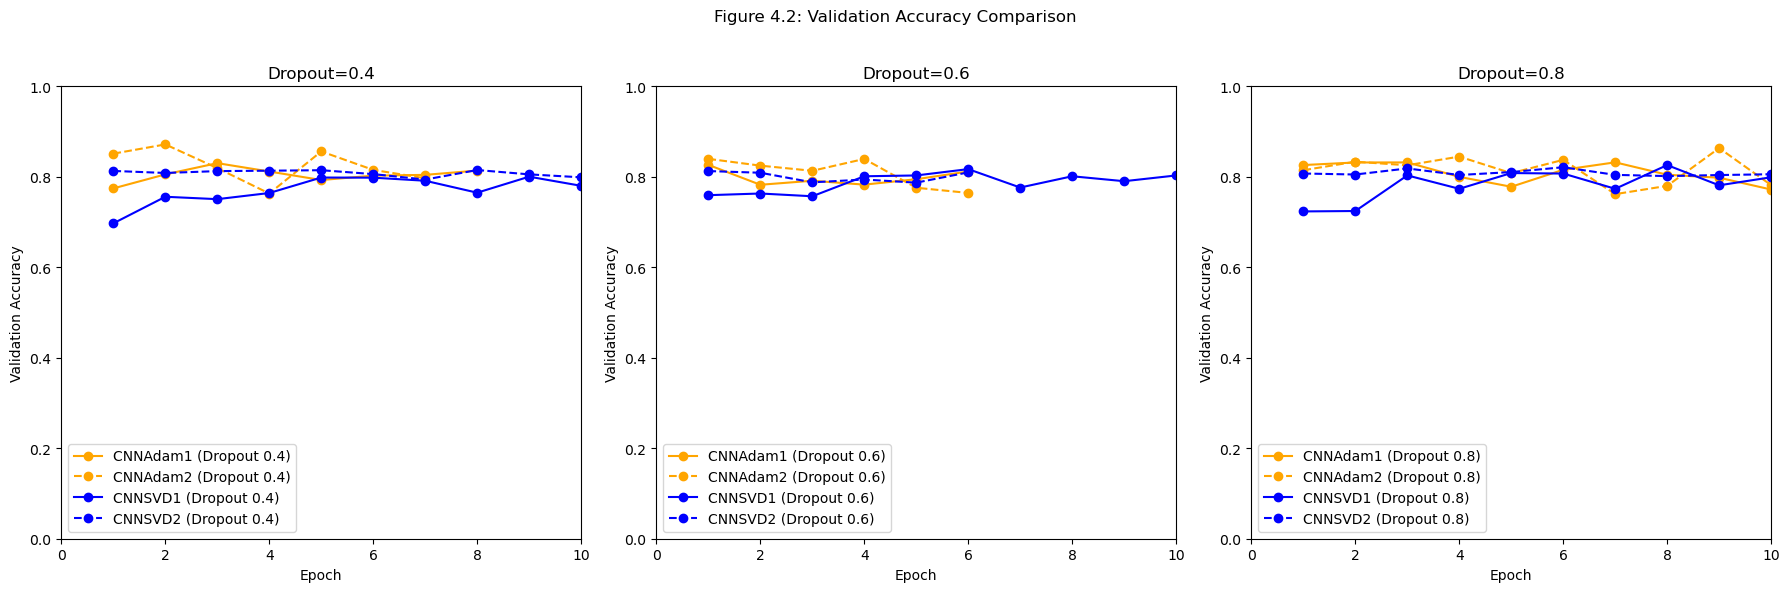

In [ ]:
# Create a figure with 3 subplots (one for each dropout rate)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Figure 4.2: Validation Accuracy Comparison')

# Define dropout values to filter data
dropout_values = [0.4, 0.6, 0.8]

# Iterate over dropout values to plot on the corresponding subplot
for i, dropout in enumerate(dropout_values):
    ax = axs[i]  # Select subplot for current dropout value

    # List of models to plot: (data, model_name, color, line style)
    models = [
        (train_log_cnnadam1, 'CNNAdam1', 'orange', '-'),
        (train_log_cnnadam2, 'CNNAdam2', 'orange', '--'),
        (train_log_cnnsvd1, 'CNNSVD1', 'blue', '-'),
        (train_log_cnnsvd2, 'CNNSVD2', 'blue', '--')
    ]

    # Iterate through each model's data
    for model_data in models:
        data, model_name, color, linestyle = model_data

        # Filter data for lr=0.001 and current dropout value
        filtered_data = data[(data['lr'] == 0.001) & (data['dropout'] == dropout)]

        # Plot validation accuracy (change train_acc to val_acc)
        ax.plot(filtered_data['epoch'], filtered_data['val_acc'], label=f'{model_name} (Dropout {dropout})',
                color=color, linestyle=linestyle, marker='o')

    # Set plot labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Accuracy')
    ax.set_title(f'Dropout={dropout}')
    ax.set_xlim(0, 10)  # Set x-axis (epochs) to 10 for all plots
    ax.set_ylim(0, 1.0)  # Set y-axis to range from 0 to 1.0
    ax.legend()

# Adjust layout to make room for the title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 4.2 Hyperparameter Review

### Dropout Rate

The dropout rate is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to zero during training. The dropout rate values used in both models were 0.4, 0.6, and 0.8, as detailed in the tables above. These values were chosen to experiment with different levels of regularization.

- **Adam2 Model**: The performance of the Adam2 model generally improves as the dropout rate increases from 0.4 to 0.8, although the validation accuracy slightly decreases in the higher dropout settings (0.8). The best performance is achieved at a dropout rate of 0.8 with a training accuracy of 0.9137 and a validation accuracy of 0.7817 at epoch 10. This suggests that a higher dropout rate in Adam2 may help with training accuracy but might result in some over-regularization that reduces validation performance.
  
- **SVD2 Model**: The SVD2 model shows similar trends, with dropout rates of 0.6 and 0.8 resulting in better regularization and training performance. The validation accuracy slightly fluctuates across different dropout values but generally remains within a competitive range. The model trained with a dropout rate of 0.8 achieved a training accuracy of 0.9033 and a validation accuracy of 0.8057 by epoch 10, indicating that a higher dropout rate tends to improve the model's robustness to overfitting.

### Learning Rate

Both models used a fixed learning rate of 0.001. This learning rate is typically considered small enough to allow for stable convergence while avoiding overshooting. The choice of a fixed learning rate instead of an adaptive one (like Adam or RMSprop) indicates a preference for simpler hyperparameter setups. It was also the significantly better performing learning rate from the first round of model training.

- **Adam2 Model**: The training and validation loss trends show that the model improves gradually across epochs, with a noticeable decrease in both loss and increase in accuracy. At the lower dropout rate (0.4), the model seems to converge faster, but with an increasing dropout rate, the training loss decreases more gradually, potentially due to the higher regularization.
  
- **SVD2 Model**: The learning rate in SVD2 behaves similarly, where the fixed value of 0.001 leads to steady performance improvements over the epochs. As seen with Adam2, SVD2 shows slight fluctuations in validation accuracy depending on the dropout rate, but overall the performance is stable across all tested dropout rates.

### Number of Epochs

The models were trained over 10 epochs, with performance metrics tracked at each epoch. This number of epochs was chosen to provide a balance between model training time and performance evaluation.

- **Adam2 Model**: The training and validation accuracies continue to improve until epoch 9, where they plateau. This suggests that the model has reached a good level of convergence, especially at dropout rates of 0.8. The validation accuracy appears to stabilize after epoch 7, indicating diminishing returns from additional epochs beyond this point for most dropout values.
  
- **SVD2 Model**: The SVD2 model shows similar trends, with training and validation accuracies gradually improving and stabilizing towards the later epochs. In the case of the 0.8 dropout rate, the model appears to converge around epoch 6, where the validation accuracy hits a peak of 0.8057.

### Impact of ResNet Backbone

The addition of the ResNet backbone in both models (Adam2 and SVD2) enhances the feature extraction capabilities, allowing the models to learn more complex representations from the input data. This addition likely contributed to the steady improvement in both training and validation accuracies, especially in the later epochs. The ResNet architecture, with its deep residual learning framework, facilitates the training of deeper networks by addressing the vanishing gradient problem, allowing for more effective learning of complex features. This backbone helps the model focus on high-level features that are beneficial for classification tasks, leading to better performance in both models across different dropout rates.

## 4.3 Final Model

Based on the comparison of models using different dropout values, the final model selected is CNNAdam2 with a dropout rate of 0.8. This combination achieved the highest final training accuracy of 0.9137 at epoch 10. The model demonstrated consistent improvement in performance across training epochs, making it the best performing model in this comparison. Moving forward, CNNAdam2 will serve as the foundation for further experimentation and fine-tuning. The choice of a dropout rate of 0.8 helps in regularizing the model, preventing overfitting while maintaining high training accuracy, which is crucial for achieving optimal generalization in future evaluations.

In [ ]:
# Define dropout values to filter data
dropout_values = [0.4, 0.6, 0.8]

# Store results for comparison
best_model_info = []

# List of models to compare
models = [
    (train_log_cnnadam1, 'CNNAdam1', 'orange'),
    (train_log_cnnadam2, 'CNNAdam2', 'orange'),
    (train_log_cnnsvd1, 'CNNSVD1', 'blue'),
    (train_log_cnnsvd2, 'CNNSVD2', 'blue')
]

# Iterate through each model and each dropout value to find the best model
for model_data in models:
    data, model_name, color = model_data

    for dropout in dropout_values:
        # Filter data for lr=0.001 and current dropout value
        filtered_data = data[(data['lr'] == 0.001) & (data['dropout'] == dropout)]

        # Get the final epoch (last available) for the current model and dropout
        final_epoch_data = filtered_data.iloc[-1]  # Last row for each dropout and model combination

        # Get the final training accuracy
        final_acc = final_epoch_data['train_acc']

        # Store the best model information
        best_model_info.append({
            'Model': model_name,
            'Dropout': dropout,
            'FinalEpoch': final_epoch_data['epoch'],
            'FinalAccuracy': final_acc
        })

# Convert to DataFrame for easy comparison
best_model_df = pd.DataFrame(best_model_info)

# Find the best model based on highest final accuracy
best_model = best_model_df.loc[best_model_df['FinalAccuracy'].idxmax()]

# Display the best model information
print("Best Model based on Final Accuracy:")
print(best_model)


Best Model based on Final Accuracy:
Model            CNNAdam2
Dropout               0.8
FinalEpoch           10.0
FinalAccuracy      0.9137
Name: 5, dtype: object


## 4.4 Final Model Predictions


In [ ]:
best_model.to(device)  # Move model to device (e.g., CUDA or CPU)

# Evaluate on the test set
best_model.eval()
test_preds = []
test_ids = []  # To store the IDs from the metadata

with torch.no_grad():
    for inputs, *rest in test_dataloader:
        inputs = inputs.to(device)

        # Assuming rest[1] contains the IDs
        ids = [item[0] for item in rest[1]]  # Extract the IDs from the second element in rest
        test_ids.extend(ids)

        # Forward pass
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)

        test_preds.extend(preds.cpu().numpy())

# Create a DataFrame with IDs and predicted labels
test_predictions_df = pd.DataFrame({
    'id': test_ids,
    'label': test_preds
})

# Save predictions to a CSV file
test_predictions_csv_path = "/content/drive/My Drive/Kaggle_CNN_Histopathology/test_predictions.csv"
test_predictions_df.to_csv(test_predictions_csv_path, index=False)

print(f"Test predictions saved to {test_predictions_csv_path}")

Test predictions saved to /content/drive/My Drive/Kaggle_CNN_Histopathology/test_predictions.csv


# 5 Conclusion

In this project, machine learning models were developed and tuned for image classification tasks on histopathologic images. Several hyperparameters, regularization techniques, and architectural choices were tested to identify the most effective configuration for optimizing model performance. This section discusses the key results, insights gained, and potential improvements that could be explored in future work.

### Results Summary and Interpretations

The models were trained using ResNet as the backbone, which proved to be a highly effective choice due to its depth and residual learning framework. This architecture enabled improved feature extraction and deeper model convergence, leading to strong performance. The models trained with ResNet showed stable convergence and high validation accuracies. The impact of varying dropout rates was notable. In general, higher dropout rates (0.6–0.8) helped improve regularization, reducing overfitting. However, validation accuracy slightly dipped at the highest dropout rate (0.8), suggesting that while regularization was beneficial, too much of it may have caused underfitting.

The learning rate of 0.001 consistently produced the best results, offering a good balance between training speed and model convergence. This rate was small enough to avoid overshooting, contributing to steady and effective learning. It was also the best-performing learning rate in earlier experiments, reinforcing its suitability for the given task.

### What Helped Improve Performance

ResNet Backbone: Integrating ResNet significantly enhanced the model’s ability to learn complex patterns from the data. Its pre-trained weights, fine-tuned for the specific task, enabled the model to leverage learned features from large datasets like ImageNet, providing a strong foundation for more accurate predictions.

Dropout Rate Selection: Higher dropout rates (0.6 and 0.8) helped prevent overfitting, improving the model's ability to generalize to unseen data. These rates effectively stabilized the learning process, although too high a rate led to some performance degradation due to underfitting.

Learning Rate Stability: A fixed learning rate of 0.001 proved optimal for steady performance, preventing overshooting and allowing for consistent learning over the course of training.

### What Did Not Help Improve Performance

Limited Epochs: The models were trained for 10 epochs, which yielded good results but showed signs of early plateaus in training and validation accuracies. Additional epochs or adjustments to the early stopping criteria could have further improved the models' convergence and final performance.

### Future Improvements
Fine-tuning Learning Rates: Although a learning rate of 0.001 was effective, experimenting with adaptive learning rates or using learning rate schedules (e.g., decreasing the rate during training) could lead to further performance gains. Cyclical learning rates could also be explored to enhance training dynamics.

Deeper Architectures or Hybrid Models: Testing deeper versions of ResNet (e.g., ResNet-50 or ResNet-101) could improve performance, especially for complex datasets like histopathologic images. Hybrid models that combine ResNet with other architectures such as Transformer-based networks may also provide an opportunity to capture both convolutional and attention-based features for better representation learning.

Data Augmentation and Regularization: While standard augmentation techniques like random rotations and flips were used, incorporating advanced strategies such as CutMix or MixUp could provide more diverse data, improving generalization. These methods have shown promise in image classification tasks and may help the model perform better with limited training data.

Ensemble Methods: Using ensemble techniques, where multiple models are trained and their predictions are averaged, could reduce variance and improve stability. This approach may boost the final model's accuracy and robustness.

Extended Training Time: Although the models were trained for 10 epochs, additional epochs might further refine the models and improve performance. Implementing learning rate annealing or experimenting with different training schedules could help achieve better results as the models continue to learn.